In [60]:
import mat73
import pandas as pd
import numpy as np
import scipy.io
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

### Data loading and preprocessing

In [61]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()) and "anuja" in os.environ.get('USER'):
    DATA_DIR = 'data/'
    

In [62]:
foof = pd.read_csv(DATA_DIR+"foof2features.csv")
foof = foof.rename(columns={"C1": "IDs" ,"C2": "Intercept", "C3": "Slope"})
foof

,IDs,Intercept,Slope
0,NDARAA075AMK,0.986272,1.825774
1,NDARAA112DMH,1.486650,1.888544
2,NDARAA117NEJ,1.593155,2.095749
3,NDARAA947ZG5,0.703331,1.724831
4,NDARAA948VFH,0.918020,1.749441
...,...,...,...
2037,NDARZN277NR6,1.351549,1.996940
2038,NDARZN578YDP,1.380795,2.036327
2039,NDARZN610GTY,0.339229,1.050644
2040,NDARZN677EYE,0.781225,1.470061


In [63]:
data = scipy.io.loadmat(DATA_DIR+'x.mat')  
df = pd.DataFrame(data['x'].reshape((data['x'].shape[0], -1)))

# sparsing
df = np.array(df).reshape(data['x'].shape)
df_sparsed = np.concatenate([np.expand_dims(df[:,:,i:i+2].mean(axis = 2), axis = 2) for i in range(0, data['x'].shape[2]-2, 2)], axis = 2)
df = pd.DataFrame(df_sparsed.reshape((df_sparsed.shape[0], -1)))

#scaling
norm = MinMaxScaler().fit(df)
df = norm.transform(df)
df = pd.DataFrame(df.reshape((df.shape[0], -1)))

columns = np.asarray([['Electrode %d - %d/2 Hz'%(i+1, j+1)] for i in range(df_sparsed.shape[1]) for j in range(df_sparsed.shape[2])])
df.columns = columns
df['IDs'] = foof['IDs']
df

,"(Electrode 1 - 1/2 Hz,)","(Electrode 1 - 2/2 Hz,)","(Electrode 1 - 3/2 Hz,)","(Electrode 1 - 4/2 Hz,)","(Electrode 1 - 5/2 Hz,)","(Electrode 1 - 6/2 Hz,)","(Electrode 1 - 7/2 Hz,)","(Electrode 1 - 8/2 Hz,)","(Electrode 1 - 9/2 Hz,)","(Electrode 1 - 10/2 Hz,)",...,"(Electrode 105 - 31/2 Hz,)","(Electrode 105 - 32/2 Hz,)","(Electrode 105 - 33/2 Hz,)","(Electrode 105 - 34/2 Hz,)","(Electrode 105 - 35/2 Hz,)","(Electrode 105 - 36/2 Hz,)","(Electrode 105 - 37/2 Hz,)","(Electrode 105 - 38/2 Hz,)","(Electrode 105 - 39/2 Hz,)",IDs
0,1.212006e-10,2.857691e-08,0.000006,0.001066,0.033290,0.143816,0.221608,0.467715,0.593581,0.401686,...,0.000007,0.000002,4.333844e-07,9.373567e-08,1.616373e-08,3.256580e-09,4.986456e-10,7.457518e-11,1.130004e-11,NDARAA075AMK
1,1.539866e-01,3.856645e-01,0.074284,0.216988,0.177267,0.161251,0.117761,0.132384,0.049898,0.004720,...,0.031636,0.009416,2.352137e-03,4.122513e-04,4.825197e-05,5.944433e-06,5.749150e-07,6.398086e-08,8.415637e-09,NDARAA112DMH
2,3.439263e-05,4.110931e-03,0.094118,0.367821,0.284890,0.164614,0.216934,0.333176,0.526883,0.511715,...,0.000311,0.000079,2.045964e-05,4.443460e-06,7.491343e-07,1.436770e-07,2.039047e-08,2.751924e-09,3.663748e-10,NDARAA117NEJ
3,2.832192e-01,3.613309e-01,0.378969,0.299813,0.247412,0.058588,0.015256,0.004514,0.003988,0.061608,...,0.158691,0.150551,1.580043e-01,1.518115e-01,1.233778e-01,1.242931e-01,1.009636e-01,8.498748e-02,7.690149e-02,NDARAA947ZG5
4,1.247342e-04,1.132987e-02,0.167700,0.368840,0.155464,0.104191,0.194459,0.288490,0.233210,0.125520,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NDARAA948VFH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,2.303407e-04,2.867255e-02,0.194945,0.081646,0.018422,0.076959,0.179779,0.300051,0.417245,0.459853,...,0.093399,0.058729,4.012462e-02,2.464919e-02,1.257993e-02,7.816617e-03,3.846395e-03,1.926406e-03,1.018633e-03,NDARZN277NR6
2038,1.385606e-02,2.124126e-02,0.032991,0.043456,0.048827,0.049759,0.074988,0.222227,0.444972,0.464653,...,0.016832,0.009602,5.877454e-03,3.190797e-03,1.418509e-03,7.564419e-04,3.146594e-04,1.311957e-04,5.687030e-05,NDARZN578YDP
2039,1.089647e-02,3.749309e-02,0.139003,0.289797,0.304728,0.196113,0.191950,0.342653,0.413368,0.344024,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NDARZN610GTY
2040,6.411911e-03,2.687961e-02,0.095551,0.241121,0.434011,0.574767,0.694741,0.815939,0.678021,0.490314,...,0.059230,0.026090,1.169173e-02,4.410850e-03,1.294309e-03,4.329110e-04,1.073561e-04,2.536768e-05,5.924775e-06,NDARZN677EYE


In [64]:
beh = pd.read_csv(DATA_DIR+"behaviorals.csv")
print('Before:'+str(beh.shape))

most_common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders',  'No Diagnosis Given', 'Other Disorders']

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)] +\
                   ['DX_' + str(i).zfill(2) + '_Sub' for i in range(1, 11)]

# removing patients with incomplete eval
initial_size = beh.shape[0]
beh = beh[beh.DX_01 != 'No Diagnosis Given: Incomplete Eval']
beh = beh.reset_index(drop=True)
new_size = beh.shape[0]

print('After:'+str(beh.shape))
print('Removing', initial_size - new_size,
      'patients as their evaluations was incomplete.')

Before:(3076, 177)
After:(2939, 177)
Removing 137 patients as their evaluations was incomplete.


In [65]:
beh.columns

Index(['Unnamed: 0', 'IDs', 'Age', 'Sex', 'ACE_Score', 'APQ_P_Total',
       'APQ_SR_Total', 'ARI_P_Total_Score', 'ARI_S_Total_Score', 'ASSQ_Total',
       ...
       'DX_10_PRem', 'DX_10_Past_Doc', 'DX_10_Presum', 'DX_10_RC', 'DX_10_Rem',
       'DX_10_RuleOut', 'DX_10_Spec', 'DX_10_Sub', 'DX_10_Time', 'NoDX'],
      dtype='object', length=177)

In [66]:
no_diagnosis_given = 'No Diagnosis Given'
diagnoses_to_ids = {disorder: i for i, disorder in enumerate(most_common_disorders)}
diagnoses_to_ids

{'Attention-Deficit/Hyperactivity Disorder': 0,
 'Anxiety Disorders': 1,
 'Specific Learning Disorder': 2,
 'Autism Spectrum Disorder': 3,
 'Disruptive': 4,
 'Communication Disorder': 5,
 'Depressive Disorders': 6,
 'No Diagnosis Given': 7,
 'Other Disorders': 8}

In [67]:
def get_disorder(data, row, index):
    disorder = data.iloc[row][category_columns[index]]

    if disorder == 'Neurodevelopmental Disorders':
        disorder = data.iloc[row][category_columns[index + 10]]

    return disorder

order_of_disorders = []
for k in range(beh.shape[0]):
    i = 0
    disorder = get_disorder(beh, k, i)
    disorders_patient = []
    while not pd.isnull(disorder):
        if disorder in diagnoses_to_ids:
            if diagnoses_to_ids[disorder] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids[disorder])
        else:
            if diagnoses_to_ids['Other Disorders'] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids['Other Disorders'])
        i += 1
        if i == len(category_columns):
            break
        disorder = get_disorder(beh, k, i)

        
    order_of_disorders.append(disorders_patient)

In [68]:
other_disorders = []
no_diagnosis_given = []
for i in order_of_disorders:
    if 7 in i:
        no_diagnosis_given.append(1)
        i.remove(7)
    else:
        no_diagnosis_given.append(0)
    if 8 in i:
        other_disorders.append(1)
        i.remove(8)
    else:
        other_disorders.append(0)

In [69]:
max_len_order = np.max([len(x) for x in order_of_disorders])

# pad with a new token denoting the pad token
pad_token = len(most_common_disorders)
bod_token = len(most_common_disorders) + 1
eod_token = len(most_common_disorders) + 2

order_of_disorders = [[bod_token] + x + [eod_token] + [pad_token] * (max_len_order - len(x)) for x in order_of_disorders]

order_of_disorders = np.array(order_of_disorders)

classes = np.zeros((len(most_common_disorders),
                    beh.shape[0]), dtype=np.int32)

df_disorders = beh[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
        applymap(lambda x: disorder in x if pd.notnull(x) else False)

    disorder_df = df_disorders[mask.any(axis=1)]

    np.add.at(classes[i], disorder_df.index.values, 1)

behaviour_data_columns = beh.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX') != -1)]

behaviour_data = beh.drop(columns=columns_to_drop)

for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

behaviour_data['order_diagnoses'] = list(order_of_disorders)

In [70]:
common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders']

labels=behaviour_data[["IDs"]+list(common_disorders)]
labels["Other Disorders"] = other_disorders
labels

/tmp/ipykernel_1061580/226828375.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels["Other Disorders"] = other_disorders


,IDs,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,Communication Disorder,Depressive Disorders,Other Disorders
0,NDARAA075AMK,0,0,0,0,0,0,0,0
1,NDARAA112DMH,1,0,0,0,1,0,0,1
2,NDARAA117NEJ,1,0,0,0,1,0,0,1
3,NDARAA306NT2,1,1,1,0,0,1,0,1
4,NDARAA504CRN,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
2934,NDARZZ007YMP,0,0,0,1,0,0,0,1
2935,NDARZZ740MLM,1,0,0,0,0,0,0,0
2936,NDARZZ810LVF,0,0,0,1,0,1,0,1
2937,NDARZZ830JM7,0,0,0,1,0,0,0,1


In [71]:
add_features = behaviour_data[['Sex', 'Age','IDs']]
add_features.shape

(2939, 3)

In [72]:
df = pd.merge(df, foof, on='IDs', how='inner')
df = pd.merge(df, labels, on='IDs', how='inner')
df = pd.merge(df, add_features, on='IDs', how='inner')
df

,"(Electrode 1 - 1/2 Hz,)","(Electrode 1 - 2/2 Hz,)","(Electrode 1 - 3/2 Hz,)","(Electrode 1 - 4/2 Hz,)","(Electrode 1 - 5/2 Hz,)","(Electrode 1 - 6/2 Hz,)","(Electrode 1 - 7/2 Hz,)","(Electrode 1 - 8/2 Hz,)","(Electrode 1 - 9/2 Hz,)","(Electrode 1 - 10/2 Hz,)",...,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,Communication Disorder,Depressive Disorders,Other Disorders,Sex,Age
0,1.212006e-10,2.857691e-08,0.000006,0.001066,0.033290,0.143816,0.221608,0.467715,0.593581,0.401686,...,0,0,0,0,0,0,0,0,1,6.728040
1,1.539866e-01,3.856645e-01,0.074284,0.216988,0.177267,0.161251,0.117761,0.132384,0.049898,0.004720,...,1,0,0,0,1,0,0,1,0,5.545744
2,3.439263e-05,4.110931e-03,0.094118,0.367821,0.284890,0.164614,0.216934,0.333176,0.526883,0.511715,...,1,0,0,0,1,0,0,1,0,7.475929
3,2.832192e-01,3.613309e-01,0.378969,0.299813,0.247412,0.058588,0.015256,0.004514,0.003988,0.061608,...,1,0,1,1,0,0,0,1,0,13.627880
4,1.247342e-04,1.132987e-02,0.167700,0.368840,0.155464,0.104191,0.194459,0.288490,0.233210,0.125520,...,1,0,0,0,0,0,0,1,1,7.982660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916,1.556547e-05,2.900630e-04,0.003548,0.023882,0.088943,0.189421,0.293481,0.445277,0.644915,0.577096,...,0,1,0,0,0,0,0,0,1,11.629363
1917,2.303407e-04,2.867255e-02,0.194945,0.081646,0.018422,0.076959,0.179779,0.300051,0.417245,0.459853,...,1,1,0,0,0,0,1,0,1,14.878736
1918,1.089647e-02,3.749309e-02,0.139003,0.289797,0.304728,0.196113,0.191950,0.342653,0.413368,0.344024,...,0,0,0,0,0,0,0,1,1,16.379534
1919,6.411911e-03,2.687961e-02,0.095551,0.241121,0.434011,0.574767,0.694741,0.815939,0.678021,0.490314,...,1,0,0,0,0,0,0,0,1,15.029545


### Data Split

In [73]:
disorders_list = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders', 'Other Disorders']
                         
#rest_list = ['Age','Sex']            
x = df[df.columns.difference(['IDs']+disorders_list)]
        
#x = df[df.columns.difference(['IDs']+disorders_list + rest_list)]
y = df[disorders_list]

# summarize dataset shape
print(x.shape, y.shape)

(1921, 4099) (1921, 8)


In [74]:
train_features, test_features, train_labels, test_labels = train_test_split(x, y, test_size=0.25, shuffle=True)

In [75]:
train_labels = np. array(train_labels) 
test_labels = np. array(test_labels) 

In [76]:
print(train_features.shape, test_features.shape)

(1440, 4099) (481, 4099)


## FEATURE EXTRACTION WITH PCA

In [77]:
#scaling features

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
train_features = norm.transform(train_features)
test_features = norm.transform(test_features)

print(train_features.shape, test_features.shape)

(1440, 4099) (481, 4099)


/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [78]:
train_features_spectra = train_features[:,:-2]
test_features_spectra = test_features[:,:-2]


In [79]:
train_features_spectra.shape
test_features_spectra.shape

(481, 4097)

In [80]:
# dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(.95) # 95% variance retained
pca.fit(train_features_spectra)

# transform data
train_features_spectra = pca.transform(train_features_spectra)
test_features_spectra = pca.transform(test_features_spectra)
print(train_features_spectra.shape, test_features_spectra.shape)

(1440, 226) (481, 226)


In [81]:
train_labels.sum(axis=0)

array([870, 472, 321, 218, 229, 198, 139, 575])

In [82]:
test_labels.sum(axis=0)

array([296, 168, 118,  74,  68,  74,  55, 182])

## Adding age and gender

In [83]:
train_features_new = np.concatenate([train_features_spectra, train_features[:,-2:]], axis = 1)
test_features_new = np.concatenate([test_features_spectra, test_features[:,-2:]], axis = 1)


In [84]:
train_features_new = train_features
test_features_new = test_features

## FEATURE EXTRACTION WITH AUTOENCODER

In [85]:
# import tensorflow as tf
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
# from tensorflow.keras.utils import plot_model, to_categorical

# n_inputs = train_features.shape[1]

# visible = Input(shape=(n_inputs,))
# e = Dense(n_inputs*2)(visible)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# e = Dense(n_inputs)(e)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# n_bottleneck = round(float(n_inputs) / 2.0)
# bottleneck = Dense(n_bottleneck)(e)

# d = Dense(n_inputs)(bottleneck)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# d = Dense(n_inputs*2)(d)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# output = Dense(8, activation='linear')(d)

# model = Model(inputs=visible, outputs=output)
# model.compile(optimizer='adam', loss='mse')
# plot_model(model, 'autoencoder_compress.png', show_shapes=True)

# history = model.fit(train_features, train_labels, epochs=50, batch_size=16, verbose=2)
# encoder = Model(inputs=visible, outputs=bottleneck)

# plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# encoder.save('autoencoder.h5')

In [86]:
# # encode the data
# encoder= load_model('autoencoder.h5', compile=False)

# train_features = encoder.predict(train_features)
# test_features = encoder.predict(test_features)

### Metrics

In [87]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

n_classes = train_labels.shape[1]

def plot_pr_curve(Y_test, y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y_test.ravel(), y_score.ravel()
    )
    average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

    _, ax = plt.subplots(figsize=(8, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(n_classes):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall curve")

    plt.show()
    
def plot_roc_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [88]:
from sklearn.metrics import hamming_loss, accuracy_score
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

def evaluate(y_test, y_pred_prob, brier=True):
    y_pred = y_pred_prob.round()
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Hamming Loss:", hamming_loss(y_test, y_pred))
    if brier:
        print("Brier Score:", brier_multi(y_test, y_pred_prob))
    print("Classification Report:\n", skm.classification_report(y_test,y_pred, zero_division=1))
    print("Confusion matrix:\n", skm.multilabel_confusion_matrix(y_test, y_pred))

## Models

### Multi Output Classifier

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

LogisticRegression():
Accuracy: 0.07068607068607069
Hamming Loss: 0.2876819126819127
Brier Score: 1.6744226405369134
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.72      0.69       296
           1       0.36      0.30      0.33       168
           2       0.22      0.14      0.18       118
           3       0.11      0.05      0.07        74
           4       0.18      0.07      0.10        68
           5       0.17      0.05      0.08        74
           6       0.40      0.15      0.21        55
           7       0.41      0.40      0.40       182

   micro avg       0.46      0.36      0.40      1035
   macro avg       0.32      0.24      0.26      1035
weighted avg       0.40      0.36      0.37      1035
 samples avg       0.55      0.43      0.36      1035

Confusion matrix:
 [[[ 75 110]
  [ 83 213]]

 [[224  89]
  [117  51]]

 [[304  59]
  [101  17]]

 [[376  31]
  [ 70   4]]

 [[390  23]
  [ 63   5]]

 [[38

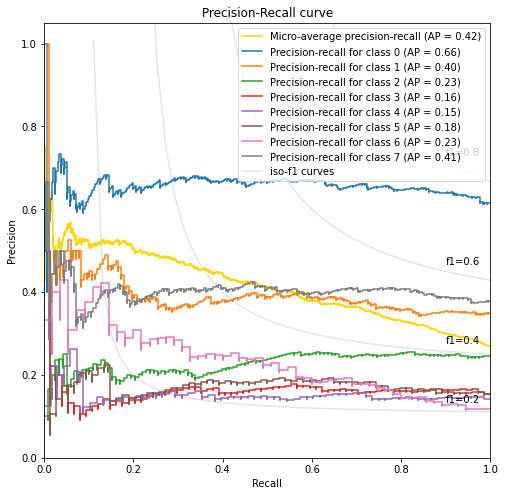

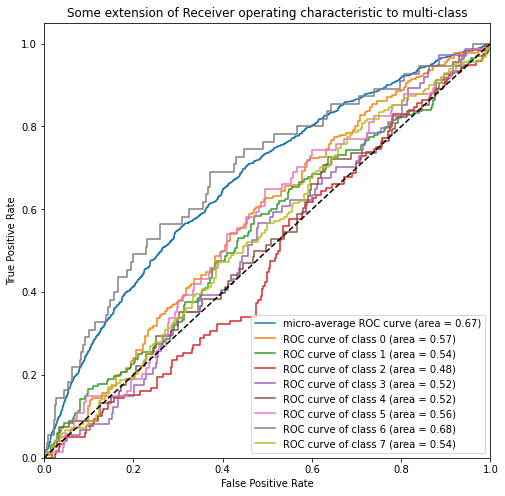

RandomForestClassifier(random_state=1):
Accuracy: 0.10395010395010396
Hamming Loss: 0.2455821205821206
Brier Score: 1.4153650727650728
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.89      0.74       296
           1       0.29      0.03      0.05       168
           2       0.33      0.01      0.02       118
           3       1.00      0.00      0.00        74
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        74
           6       0.33      0.02      0.03        55
           7       0.46      0.13      0.21       182

   micro avg       0.59      0.29      0.38      1035
   macro avg       0.38      0.14      0.13      1035
weighted avg       0.44      0.29      0.26      1035
 samples avg       0.64      0.38      0.36      1035

Confusion matrix:
 [[[ 30 155]
  [ 32 264]]

 [[301  12]
  [163   5]]

 [[361   2]
  [117   1]]

 [[407   0]
  [ 74   0]]

 [[408   5]
 

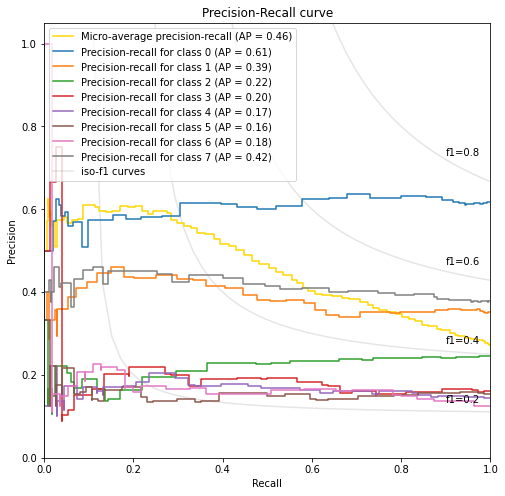

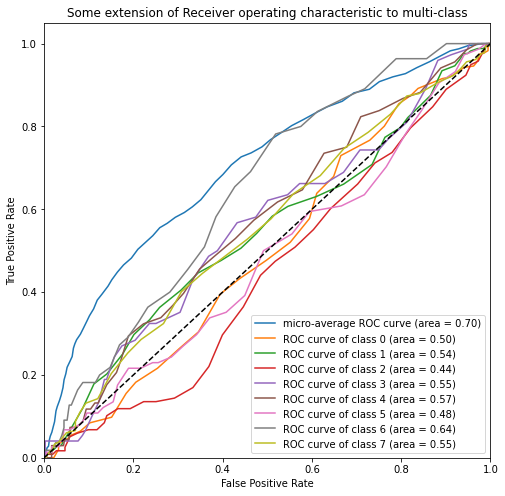

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
forest = RandomForestClassifier(random_state=1)
lg = LogisticRegression()
models = [lg, forest]

for model in models:

    multi_output_model = MultiOutputClassifier(model, n_jobs=-1)
    multi_output_model.fit(train_features, train_labels)
    predicted_labels = np.asarray(multi_output_model.predict_proba(test_features))[:, :, 1].T
    print(str(model)+':')
    evaluate(test_labels, predicted_labels)
    plot_pr_curve(test_labels, predicted_labels)
    plot_roc_curve(test_labels, predicted_labels)

### MLP simple

Epoch 1/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5372
Epoch 2/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5119
Epoch 3/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5025
Epoch 4/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4980
Epoch 5/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4906
Epoch 6/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4806
Epoch 7/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4681
Epoch 8/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4588
Epoch 9/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4539
Epoch 10/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4462
Epoch 11/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4402
Epoch 12/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4301
Epoch 13/100
45/45 [=================

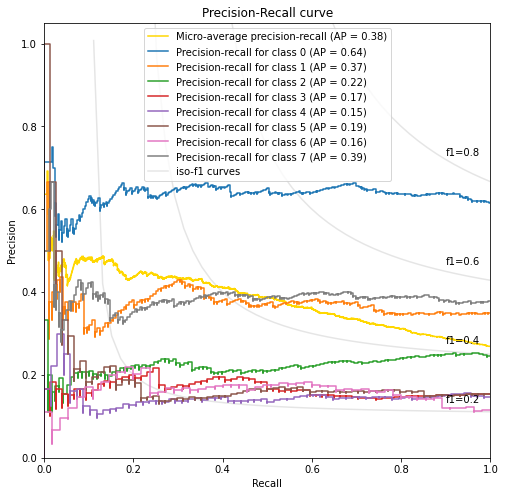

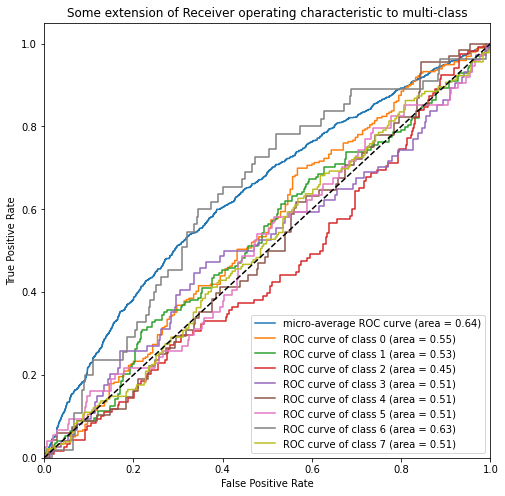

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
mlp = get_mlp(n_inputs, n_outputs)
mlp.fit(train_features, train_labels, verbose=1, epochs=100)

predicted_labels_mlp = mlp.predict(test_features)
evaluate(test_labels, predicted_labels_mlp)

plot_pr_curve(test_labels, predicted_labels_mlp)
plot_roc_curve(test_labels, predicted_labels_mlp)

## MLP more complicated

Epoch 1/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5388
Epoch 2/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5195
Epoch 3/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5135
Epoch 4/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5097
Epoch 5/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5037
Epoch 6/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5002
Epoch 7/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4975
Epoch 8/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4933
Epoch 9/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4897
Epoch 10/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4848
Epoch 11/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4787
Epoch 12/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4725
Epoch 13/100
45/45 [=================

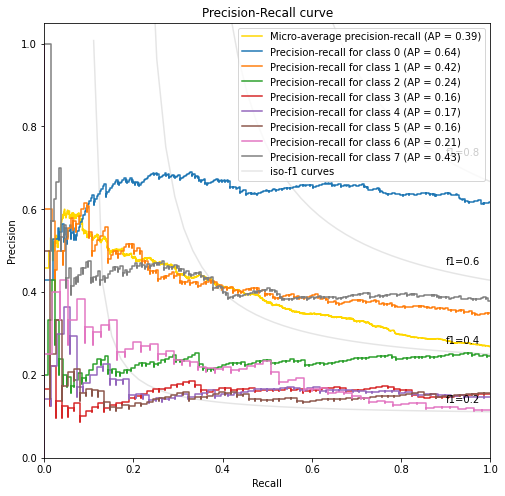

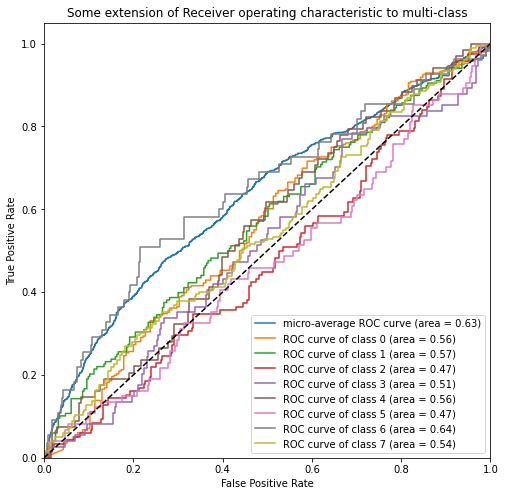

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))

    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
mlp = get_mlp(n_inputs, n_outputs)
mlp.fit(train_features, train_labels, verbose=1, epochs=100)

predicted_labels_mlp = mlp.predict(test_features)
evaluate(test_labels, predicted_labels_mlp)

plot_pr_curve(test_labels, predicted_labels_mlp)
plot_roc_curve(test_labels, predicted_labels_mlp)

### Binary Relevance
ignores the possible correlations between class labels

Accuracy: 0.0
Hamming Loss: 0.4901247401247401
Brier Score: 3.905290749204944
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.40      0.49       296
           1       0.33      0.66      0.44       168
           2       0.24      0.71      0.36       118
           3       0.14      0.24      0.18        74
           4       0.16      0.46      0.24        68
           5       0.14      0.35      0.20        74
           6       0.13      0.73      0.22        55
           7       0.41      0.30      0.34       182

   micro avg       0.27      0.46      0.34      1035
   macro avg       0.27      0.48      0.31      1035
weighted avg       0.37      0.46      0.37      1035
 samples avg       0.27      0.51      0.30      1035

Confusion matrix:
 [[[118  67]
  [179 117]]

 [[ 92 221]
  [ 57 111]]

 [[102 261]
  [ 34  84]]

 [[297 110]
  [ 56  18]]

 [[250 163]
  [ 37  31]]

 [[242 165]
  [ 48  26]]

 [[159 267]
  [ 15

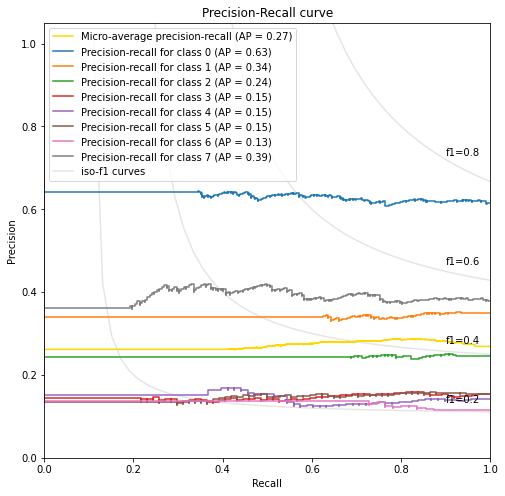

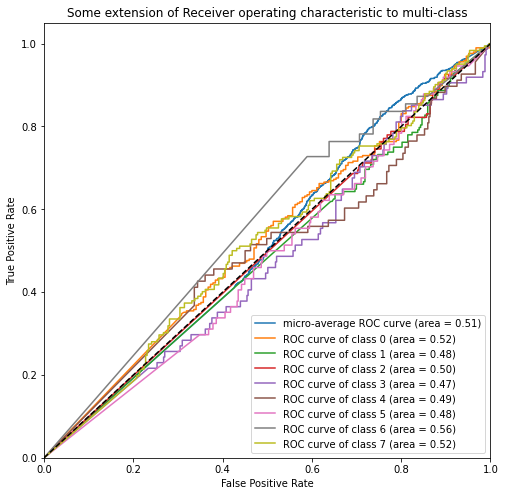

In [92]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

classifier = BinaryRelevance(GaussianNB())
classifier.fit(train_features, train_labels)


predicted_labels_br = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_br.toarray())

plot_pr_curve(test_labels, predicted_labels_br.toarray())
plot_roc_curve(test_labels, predicted_labels_br.toarray())

### Classfier Chains

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Accuracy: 0.07692307692307693
Hamming Loss: 0.28794178794178793
Brier Score: 1.6883791582020276
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.72      0.69       296
           1       0.38      0.30      0.34       168
           2       0.22      0.14      0.18       118
           3       0.11      0.07      0.08        74
           4       0.20      0.12      0.15        68
           5       0.11      0.03      0.04        74
           6       0.31      0.09      0.14        55
           7       0.43      0.32      0.37       182

   micro avg       0.45      0.35      0.39      1035
   macro avg       0.30      0.22      0.25      1035
weighted avg       0.40      0.35      0.36      1035
 samples avg       0.58      0.42      0.35      1035

Confusion matrix:
 [[[ 75 110]
  [ 82 214]]

 [[228  85]
  [117  51]]

 [[304  59]
  [101  17]]

 [[367  40]
  [ 69   5]]

 [[380  33]
  [ 60   8]]

 [[390  17]
  [ 72   2]]



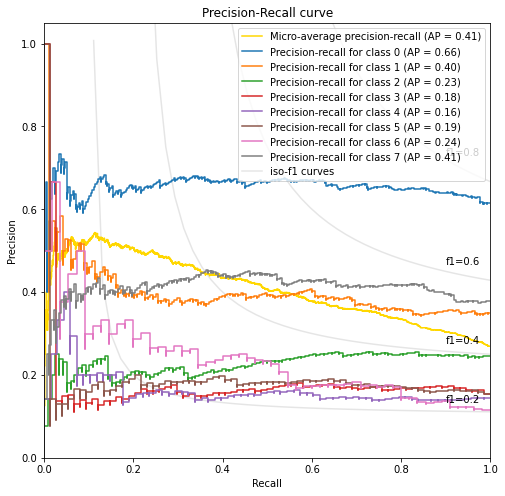

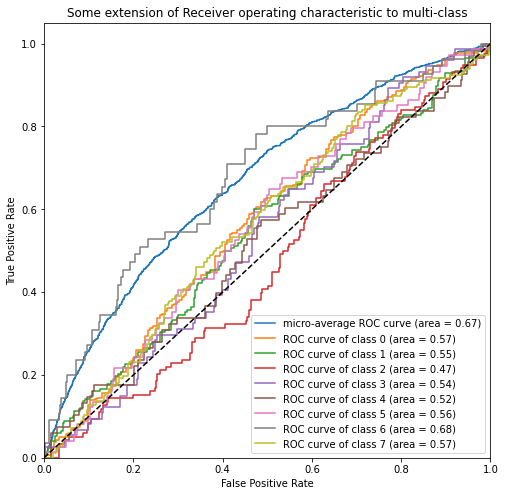

In [93]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

classifier = ClassifierChain(LogisticRegression())
classifier.fit(train_features, train_labels)
# we should optimise this a little

predicted_labels_cc = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_cc.toarray())

plot_pr_curve(test_labels, predicted_labels_cc.toarray())
plot_roc_curve(test_labels, predicted_labels_cc.toarray())

### Label Powerset
takes correlations into account!

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.07692307692307693
Hamming Loss: 0.2622141372141372
Brier Score: 1.5046372479928494
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.75      0.70       296
           1       0.34      0.17      0.22       168
           2       0.12      0.02      0.03       118
           3       0.23      0.04      0.07        74
           4       0.15      0.03      0.05        68
           5       0.40      0.03      0.05        74
           6       0.67      0.04      0.07        55
           7       0.40      0.25      0.31       182

   micro avg       0.52      0.30      0.38      1035
   macro avg       0.37      0.17      0.19      1035
weighted avg       0.42      0.30      0.31      1035
 samples avg       0.63      0.38      0.33      1035

Confusion matrix:
 [[[ 65 120]
  [ 73 223]]

 [[259  54]
  [140  28]]

 [[348  15]
  [116   2]]

 [[397  10]
  [ 71   3]]

 [[402  11]
  [ 66   2]]

 [[404   3]
  [ 72   2]]

 

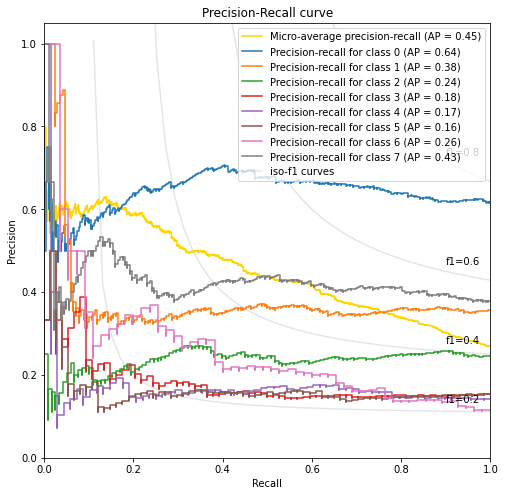

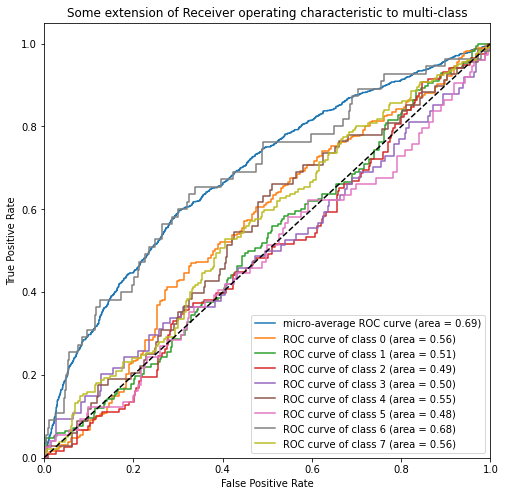

In [94]:
from skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(LogisticRegression())
classifier.fit(train_features, train_labels)

predicted_labels_lp = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_lp.toarray())

plot_pr_curve(test_labels, predicted_labels_lp.toarray())
plot_roc_curve(test_labels, predicted_labels_lp.toarray())

Accuracy: 0.0997920997920998
Hamming Loss: 0.24506237006237006
Brier Score: 1.3921869022869025
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.94      0.75       296
           1       0.00      0.00      0.00       168
           2       1.00      0.00      0.00       118
           3       1.00      0.00      0.00        74
           4       1.00      0.00      0.00        68
           5       1.00      0.00      0.00        74
           6       1.00      0.00      0.00        55
           7       0.20      0.02      0.04       182

   micro avg       0.60      0.27      0.37      1035
   macro avg       0.73      0.12      0.10      1035
weighted avg       0.59      0.27      0.22      1035
 samples avg       0.63      0.38      0.36      1035

Confusion matrix:
 [[[ 14 171]
  [ 18 278]]

 [[310   3]
  [168   0]]

 [[363   0]
  [118   0]]

 [[407   0]
  [ 74   0]]

 [[413   0]
  [ 68   0]]

 [[407   0]
  [ 74   0]]

 

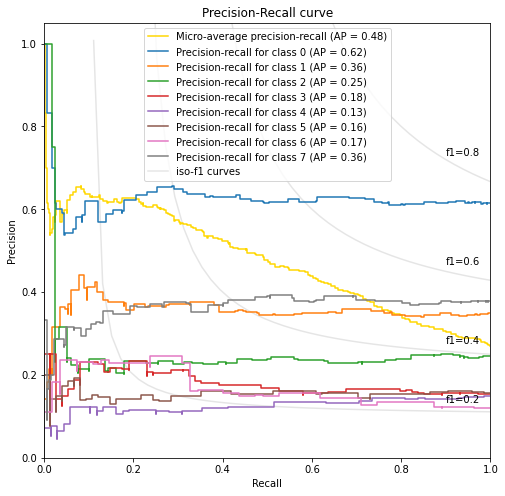

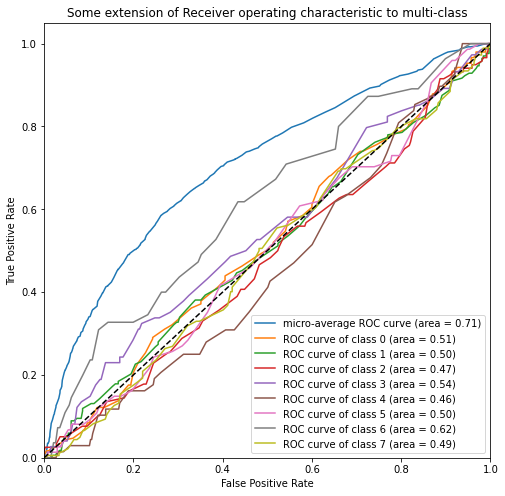

In [95]:
from skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(RandomForestClassifier())
classifier.fit(train_features, train_labels)

predicted_labels_lp = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_lp.toarray())

plot_pr_curve(test_labels, predicted_labels_lp.toarray())
plot_roc_curve(test_labels, predicted_labels_lp.toarray())